# Импорт библиотек

In [1]:
!pip install geopandas folium rasterio albumentations -q

In [73]:
import numpy as np


import pandas as pd
import geopandas as gpd

import folium

import rasterio
from rasterio.plot import show
from rasterio.mask import mask

import matplotlib.pyplot as plt
import albumentations as A

import os

# 1. Загрузка карт


### Используя специализированные библиотеки работы с геоданными, загрузим исходные файлы в векторном ГИС-формате – 3 слоя.

In [2]:
etalons = gpd.read_file('../forests-wgs84/wgs84-etalons.shp').dropna()
boundary = gpd.read_file('../forests-wgs84/wgs84-forestry-bounds.shp')
clearcuts = gpd.read_file('../forests-wgs84/wgs84-etalons-clearcuts.shp')

### Соединим 3 слоя, получим полную карту. Визуализируем ее.

In [3]:
all_map = pd.concat([boundary, etalons, clearcuts])
all_map.head(3)

,name,geometry,Kv,Sknr,Kf1,Mr1,Amz1,H1,D1,Skal1,...,ОЗУ,ущерб,наруш,вид_о?,резул,номе_2,дата_4,приме,приро,objectid
0,границ,"MULTIPOLYGON (((64.99939 56.14001, 64.99937 56...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"POLYGON ((64.85809 56.26744, 64.85822 56.26739...",1.0,3.0,0.0,000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"POLYGON ((64.85459 56.26687, 64.85505 56.26742...",1.0,4.0,8.0,Б,65.0,23.0,26.0,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

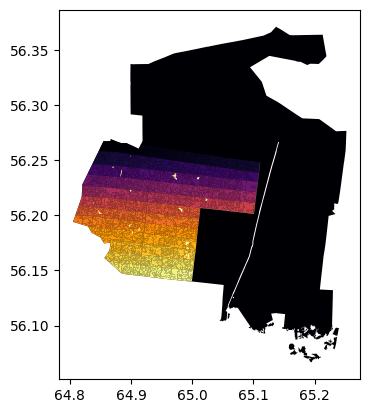

In [4]:
all_map.plot(cmap='inferno')

# 2. Загрузка исходных данных и подготовка данных к анализу


### Загрузим полностью основной набор изображений, предоставленный разработчиком задания из папки “images”. 

In [10]:
images = os.listdir('../images/')

673d62c1D36ebD4e58Da73bD2e6269da6532_B02e_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B02_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B03e_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B03_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B04e_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B04_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B05_20m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B06_20m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B07_20m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B08_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B09_60m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B11_20m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B12_20m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_B8A_20m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_barrensoil_10m.tif
673d62c1D36ebD4e58Da73bD2e6269da6532_cloudmask_20m.tif
ndmi.tiff
ndvi.tiff


### Соберем из нескольких каналов (RGB) – единый композит (единое изображение) для каждого снимка. 

In [26]:
rgb_images = {}

for image in images:
    img_parts =  image.split('_')
    if len(img_parts) > 1:
        img_name = img_parts[0]
        channel = img_parts[1]
        if channel in ['B02', 'B03', 'B04']:
            img_channels = rgb_images.get(img_name, [])
            img_channels.append(channel)
            rgb_images[img_name] = img_channels
            

rgb_images

{'673d62c1D36ebD4e58Da73bD2e6269da6532': ['B02', 'B03', 'B04']}

In [ ]:
b02_ds = rasterio.open(f'../images/{img_name}_b02_10m.tif')
        b02, meta = b02_ds.read(1).astype(np.float32), b02_ds.meta

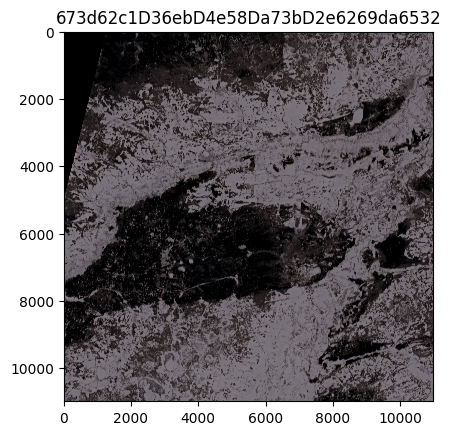

In [67]:
for img_name in rgb_images:
    if len(rgb_images[img_name]) == 3:
        b02_ds = rasterio.open(f'../images/{img_name}_b02_10m.tif')
        b02, meta = b02_ds.read(1).astype(np.float32), b02_ds.meta
        b03_ds = rasterio.open(f'../images/{img_name}_b03_10m.tif')
        b03, meta = b03_ds.read(1).astype(np.float32), b03_ds.meta

        b04_ds = rasterio.open(f'../images/{img_name}_b04_10m.tif')
        b04, meta = b04_ds.read(1).astype(np.float32), b04_ds.meta

        img_rgb = np.stack([b02, b03, b04], axis=2)
        img_rgb /= img_rgb.max()

        plt.imshow(img_rgb)
        plt.title(img_name)
        plt.show()

        meta['count'] = 3
        meta['dtype'] = 'float32'
        with rasterio.open(f'../images/{img_name}_rgb.tiff', 'w', **meta) as src:
            src.write(np.moveaxis(img_rgb, 2, 0))

In [49]:
def load_tiff(img_path):
    with rasterio.open(img_path) as img_rast:
        return img_rast.read(1).astype(np.float32), img_rast.meta

b02, meta = load_tiff('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B02_10m.tif')
b03, _ = load_tiff('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B03_10m.tif')
b04, _ = load_tiff('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B04_10m.tif')


# Собираем RGB (B04 - Красный, B03 - Зеленый, B02 - Синий)
img = np.stack([b04, b03, b02], axis=0)
img /= img.max() if img.max() > 0 else 1  # Масштабируем от 0 до 1

### Наложим Shape -файлы на RGB-композиты – для привязки к геокоординатам и предоставленным данным для каждого ареала леса. 

<Axes: >

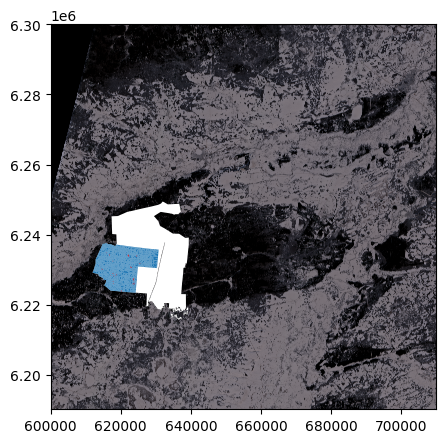

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))

show(img, transform=meta['transform'], ax=ax)

boundary = boundary.to_crs(meta['crs'])
boundary.plot(ax=ax, color='white')

etalons = etalons.to_crs(meta['crs'])
etalons.plot(ax=ax)

clearcuts = clearcuts.to_crs(meta['crs'])
clearcuts.plot(ax=ax, color='red')

### Используя Shape-файлы с участками, нарежем спутниковые снимки на полигоны (ареалы), подготовить набор данных для последующего анализа. 

In [51]:
# Проходим по каждому полигону

with rasterio.open('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_rgb.tiff') as src:
     for idx, row in etalons.iterrows():
        geom = row["geometry"])  # Геометрия полигона
    
        # Вырезаем снимок по полигону
        out_image, out_transform = mask(src, geom, crop=True)
    
        # Обновляем метаданные для обрезанного снимка
        meta.update({"height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
        # Сохраняем вырезанный снимок
        output_path = os.path.join('../cropped', f"crop_{idx}.tif")
        with rasterio.open(output_path, "w", **meta) as dest:
            dest.write(out_image)
    
        print(f"Сохранен участок {idx}: {output_path}")

Сохранен участок 0: ../cropped\crop_0.tif
Сохранен участок 1: ../cropped\crop_1.tif
Сохранен участок 2: ../cropped\crop_2.tif
Сохранен участок 3: ../cropped\crop_3.tif
Сохранен участок 4: ../cropped\crop_4.tif
Сохранен участок 5: ../cropped\crop_5.tif
Сохранен участок 6: ../cropped\crop_6.tif
Сохранен участок 7: ../cropped\crop_7.tif
Сохранен участок 8: ../cropped\crop_8.tif
Сохранен участок 9: ../cropped\crop_9.tif
Сохранен участок 10: ../cropped\crop_10.tif
Сохранен участок 11: ../cropped\crop_11.tif
Сохранен участок 12: ../cropped\crop_12.tif
Сохранен участок 13: ../cropped\crop_13.tif
Сохранен участок 14: ../cropped\crop_14.tif
Сохранен участок 15: ../cropped\crop_15.tif
Сохранен участок 16: ../cropped\crop_16.tif
Сохранен участок 17: ../cropped\crop_17.tif
Сохранен участок 18: ../cropped\crop_18.tif
Сохранен участок 19: ../cropped\crop_19.tif
Сохранен участок 20: ../cropped\crop_20.tif
Сохранен участок 21: ../cropped\crop_21.tif
Сохранен участок 22: ../cropped\crop_22.tif
Сохранен

# 3. Расширение набора данных с помощью методов аугментации

Проведем аугментацию для не менее 10 изображений (снимков).

In [50]:
aug_img.reshape((1,) + aug_img.shape)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 1830, 1830), dtype=uint8)

In [54]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5), # Выполнены зеркальные отражения
    A.RandomRotate90(p=0.5), # Выполнены повороты
    A.RandomScale(scale_limit=(-0.5, 0.5)), # Выполнены приближения/отдаления (зумы)
    A.RandomBrightnessContrast(), # Выполнена смена яркости и контрастности
    A.RandomCrop(width=1830, height=1830), # Используются обрезки (кропы)
    A.Rotate() # Используются наклоны и вращения 
], seed=137, strict=True)

for img_path in os.listdir('../images'):
    ds = rasterio.open(f'../images/{img_path}')
    meta = ds.meta.copy()
    try:
        aug_img = transform(image=ds.read(1))['image']
        aug_img = aug_img.reshape((1,) + aug_img.shape)
    
        # Сохраняем аугментированный снимок
        output_path = os.path.join('../aug_images', f"aug_{img_path}")
        with rasterio.open(output_path, "w", **meta) as dest:
            dest.write(aug_img)
        
    except Exception as e:
        print(f'Ошибка aугментации для {img_path}:')
        print(e)

Ошибка aугментации для 673d62c1D36ebD4e58Da73bD2e6269da6532_barrensoil_10m.tif:
dtype('int16')


# 4. Формирование итогового набора предобработанных данных

### Сформирован набор данных для обучения, включающий основной набор данных, дополненный изображениями, полученными в результате аугментации.

### Итоговый набор данных содержит разметку для всех изображений – по составу древесной породы.

### Итоговый набор данных изображений и разметок сохранен в архив с расширением .zip

# Отчет

В ходе выполнения модуля A было выполнено следующее:
- Загружены карты
- Загружены изображения
- Выполнена аугментация
- Сформирован итоговой предобработанный набор данных